<a href="https://colab.research.google.com/github/RusnacAM/DL-labs/blob/main/Lab2_FeatureExtractionAndTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction and transfer learning with pre-trained CNNs
Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:* Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.

## Task 1: Downloading the dataset

In this lab we'll be using a small dataset containing images of cats, dogs, and horses.

To download the dataset, run the code cell below.

In [ ]:
import gdown

# File ID
file_id = "1KDMC39ba1MAL83FLLoSVSJY2KOmFR1aj"
output = "data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KDMC39ba1MAL83FLLoSVSJY2KOmFR1aj
From (redirected): https://drive.google.com/uc?id=1KDMC39ba1MAL83FLLoSVSJY2KOmFR1aj&confirm=t&uuid=6d07098d-7353-42e3-a23d-f525e788761a
To: /content/data.zip
100%|██████████| 108M/108M [00:02<00:00, 43.1MB/s]


'data.zip'

Now, unzip the data file and show the contents of the `data` folder:

In [ ]:
!unzip -q data.zip
!ls data

cat  dog  horse


Verify that the data folder contains a subfolder for each of the classes (i.e., cat, dog, and horse).

Let's display one of the cat images:

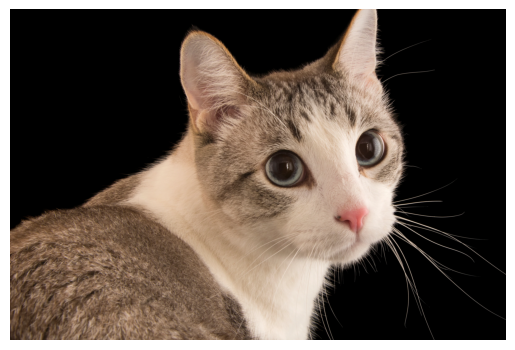

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("./data/cat/05069002-c34e-4d79-adaa-11760eb613ee.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); # Recall OpenCV reads images as BGR
plt.axis('off');

## Task 2 (optional): Mount your Google Drive and upload the data file
Save this notebook to your Google Drive by selecting "Save" or "Save a copy in Drive" in the Files menu.

If you want to store data permanently, you also need to mount your Google Drive, which can be done as follows:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Your Google Drive is now mounted in `/content/gdrive/MyDrive`, and you can use normal shell commands to create directories and copy files to/from Google Drive.

For instance, to copy the data file to the root of your Google Drive, you can run this:

In [ ]:
!cp data.zip /content/gdrive/MyDrive

And similarly, to copy the data file from your Google Drive to your Colab notebook environment, you can run

In [ ]:
!cp /content/gdrive/MyDrive/data.zip .

## Task 3: Set up neural network for feature extraction
We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will be covering both of them today. Let's start with feature extraction.

Feature extraction consists of using the representations learned by an existing neural network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. This could be any classifier, such as K-Nearest Neighbours (KNN).

Traditional CNNs are divided into two parts: they start with a series of convolution and pooling layers, and they end with a densely-connected classifier. The first part is often referred to as the "encoder", "feature extractor" or "convolutional base" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output. The second part of the network, called the "decoder" or "top layers", is ignored for now. We will be using it for fine-tuning (Transfer Learning) in Task 10.

First, let's download and instantiate the pre-trained MobileNet without the top layers (i.e., without the decoder).

You can ignore the warning.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

/tmp/ipython-input-1881398002.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(weights='imagenet',


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's summarize the model used for feature extraction:

In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 60, 60, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 60, 60, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 60, 60, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 60, 60, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 30, 30, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 30, 30, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 30, 30, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 30, 30, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

That's a lot to digest if you haven't seen a convolutional neural network before. By the end of the course, you will know what it all means. For now, see if you can figure out the answers to these questions:

### Questions 3.1
1. What is the expected shape of the input image?
The expected shape for the input image is (120, 120, 3), square size 120x120 with 3 channels
2. What is the shape of the output of the model?
The output shape would be (3, 3, 1024) with 3x3 spatial resolution and 1024 feature channels
3. What happens to the output shape if you double the size of the input image?
if you double the size of the image from 120 to 240, by default MobileNet downsamples the input by a factor of 32, so the final shape in this case would be (7, 7, 1024)
4. Can you guess what the None dimension is used for?
None is the batch size, so in this case 1 image - None

## Task 4: Preprocessing
Many neural networks expect the input image to have a fixed, pre-defined shape. Also, the pixel intensities are assumed to be in a fixed range.

For reasons that will become clear later in the course, neural networks do not work well on images in which the intensities lie in the standard range from 0 to 255. Instead, we want the intensities to be centered around zero. Typical intensity ranges are -127.5 to 127.5 or -1 to 1, but it depends on the chosen neural network architecture. Each pre-trained network in Keras comes with its own *preprocessor*, which assures that the intensities are scaled correctly for that particular network.

In summary, *preprocessing* refers to the step of preparing the image to be fed into the network by making sure the image has the right shape, and that the intensities are in the correct range.

Let's load an image, preprocess it, and feed it through the network:

In [ ]:
from pathlib import Path
import numpy as np
import keras.utils as image
from keras.applications.mobilenet import preprocess_input

classes = ['cat','dog','horse']

# Pick first image of first class (i.e., cat)
p = Path("/content/data")
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)

print("Before processing: ", img_data.min(), "-", img_data.max())

img_data = np.expand_dims(img_data, axis=0)

print("Size: ", img_data.size)

img_preprocessed = preprocess_input(img_data.copy())

print("After processing: ", img_preprocessed.min(), "-", img_preprocessed.max())

# Feed preprocessed image through CNN encoder to get a new feature representation
mobilenet_features = conv_base.predict(img_preprocessed)

print("Size: ", mobilenet_features.size)

File path: /content/data/cat/6f307ba6-0165-4bf3-b19a-33511c3db11d.jpg
Before processing:  0.0 - 255.0
Size:  43200
After processing:  -1.0 - 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Size:  9216


### Questions 4.1
1. What is the range of the pixel values before and after preprocessing?
The range of the pixel values before preprocessing is 0 - 255, and after -1 - 1
2. So what formula do you think is used to pre-process the pixel values?
the formula varies by the model used, for MobileNet it is x / 127.5 - 1
3. What is the order of the color channels? (you could compare with ``cv2.imread``, which we know reads images as BGR)
order of the color channels should be RGB
4. What is the size of the input image (``img_data`` after calling ``np.expand_dims``)?
43200
5. What is the size of the calculated feature representation (`mobilenet_features`)?
9216
6. So what is the reduction in dimensionality after feature extraction?

## Task 5: Feature maps
As we have seen above, a convolutional neural network consists of many layers. Each layer performs some mathematical operation on the output of the previous layer. The operations have names like ``Conv2D`` , ``BatchNormalization``, ``ReLU``, and ``DepthwiseConv2D``, which you will learn about during the course.

The output of a layer is referred to as a **feature map**.

Let's look at some feature maps produced by the first layer:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Feature map size: 60x60x32


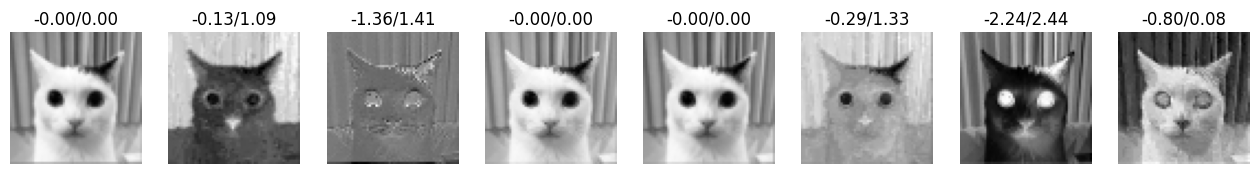

In [ ]:
from keras import Model

def show_feature_maps_from_layer(layer_name='conv1',img=img_preprocessed):
  dummy_model = Model(inputs=conv_base.input, outputs=conv_base.get_layer(layer_name).output)
  out = (dummy_model.predict(img)).squeeze()
  height = out.shape[0]
  width = out.shape[1]
  num_channels = out.shape[2]
  print(f'Feature map size: {height}x{width}x{num_channels}')

  plt.figure(figsize=(16,16))
  for i in range(8): # only display first 8 feature maps (channels)
    f = out[:,:,i]
    plt.subplot(1,8,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

# See conv_base.summary() for complete list of layer names
show_feature_maps_from_layer(layer_name='conv1')

Because this layer (``conv1``) is a convolution layer, each feature map results from applying a filter to the input image. As you can see, different filters highlight different features of the input image. The next layer in the network then takes these feature maps and transforms them somehow to extract new and more abstract features. In one of the later layers (``conv_dw_2``) we can still sort-of see the cat in the feature maps:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Feature map size: 30x30x64


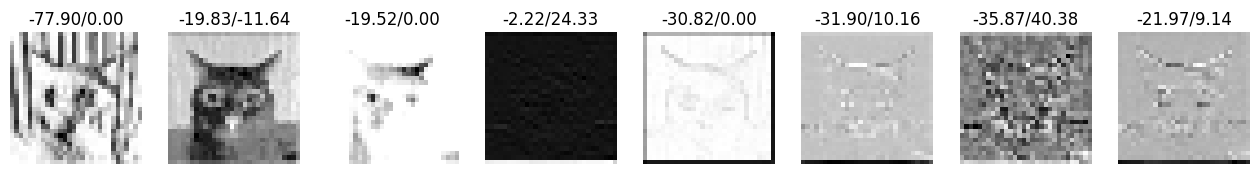

In [ ]:
show_feature_maps_from_layer(layer_name='conv_dw_2')

In the last feature map it is impossible for us to see that there was originally a cat in the input image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Feature map size: 3x3x1024


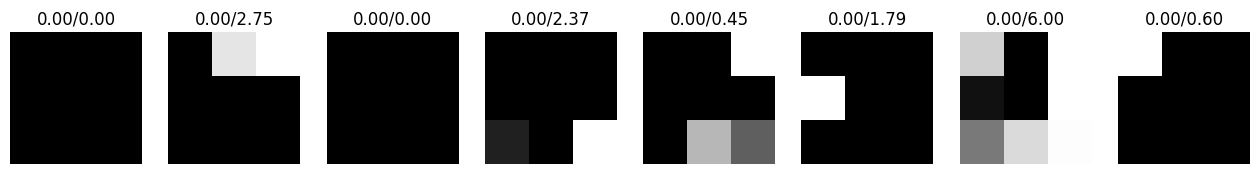

In [ ]:
show_feature_maps_from_layer(layer_name='conv_pw_13_relu')

### Question 5.1
1. Notice that the height and width of the feature maps become smaller and smaller as we move deeper into the network. Why do you think that is?
the more layers you go throught the image passes through different layers that are reduce its size, like the pooling layer and stride convolutions which downsample the spatial dimensions
2. If the last feature map is only three pixels high and three pixels wide (shape is ``3x3x1024``), how can the neural network know that there is a cat in the image, i.e, where is that information encoded in the feature map?
the 3x3 pixels encode information about a large receptieve field,
the information is encoded in the feature channels, like patterns, the 1024 part of 3x3x1024

##Task 6: How to use the image generator
Loading and preprocessing images is such a common task in deep learning that frameworks like Keras provide predefined tools for us that we can use.
In this task we will look at Keras' image data generator: https://keras.io/preprocessing/image/#imagedatagenerator-class. Simply put, the image generator is a tool that makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 8 images:


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True)

Found 241 images belonging to 3 classes.


**Note:** Check that the classes assigned by the generator are consistent with your class assignment:

In [ ]:
print('generator:',generator.class_indices)
print('your\'s:',dict((class_name,class_index) for class_index,class_name in enumerate(classes)))

generator: {'cat': 0, 'dog': 1, 'horse': 2}
your's: {'cat': 0, 'dog': 1, 'horse': 2}


Here is one way to generate a new batch:

In [ ]:
inputs, labels = generator.__getitem__(0)

print(labels[2])

[0. 0. 1.]


### Questions 6.1
1. What is variable ``inputs``? (Hint: look at the shape)
inputs is the images in batches of 8 with original size 120x120 and 3 color channels
2. What is variable ``labels``?
labels has values of arrays with size 3, which indicate the label of the image, for example value [0. 0. 1.] - horse
3. How does the image generator know where the images are stored?
the path is given in the flow_from_directory function
4. How does the image generator know the class of each image?
see point 3
5. What does shuffle mean?
it randomisez the order of the images when generating batches so they don't appear in the same order as in the directory

As you learned in lecture 2 it is always a good idea to split the data into a training set and a validation set. Again, this is such a common task in deep learning that the image generator can do it for us:

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 195 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


### Questions 6.2
1. How does each of the two generators know if it should produce training or validation images?
due to the parameter subset='training/validation' it know to automatically split the data set into training and validation
2. What is the validation percentage in this example?
0.2 so 20%

## Task 7: Feature extraction
Our goal is to train a machine learning model to correctly classify images belonging to the chosen categories (cat, dog, horse). Today, we will be using KNN, which operates on vectors. Therefore, we have to convert our images into vectors.

We have two choices of features:

1. Raw pixel values
2. MobileNet features

Besides the features we will of course also need the labels (cat, dog, horse).

Let's create the datasets that we will be using:


In [ ]:
def extract_features(generator):
  generator.reset()
  raw_pixel_features_list = []
  mobilenet_features_list = []
  labels_list = []
  batch_index = 0
  while batch_index < generator.num_batches:
    # Load mini-batch
    raw_pixels, labels = generator.__getitem__(batch_index)

    # Run through MobileNet encoder
    mobilenet_features = conv_base.predict(raw_pixels) # This is where we apply the CNN

    # Vectorize images
    bs,h,w,c = raw_pixels.shape
    raw_pixels = np.reshape(raw_pixels,(bs,h*w*c)) # vectorize

    # Vectorize MobileNet features
    bs,h,w,c = mobilenet_features.shape
    mobilenet_features = np.reshape(mobilenet_features,(bs,h*w*c)) # vectorize

    # Convert one-hot encoding to class index
    labels = np.argmax(labels,axis=1)

    # Save in lists
    for i in range(bs):
      raw_pixel_features_list.append(raw_pixels[i])
      mobilenet_features_list.append(mobilenet_features[i])
      labels_list.append(labels[i])

    batch_index = batch_index + 1

  # Convert lists to numpy arrays
  raw_pixel_features = np.asarray(raw_pixel_features_list)
  mobilenet_features = np.asarray(mobilenet_features_list)
  labels = np.asarray(labels_list)

  return raw_pixel_features, mobilenet_features, labels

In [ ]:
train_features_raw, train_features_mobilenet, train_labels = extract_features(train_generator)
validation_features_raw, validation_features_mobilenet, validation_labels = extract_features(validation_generator)

Show the first 32 images of the validation data set:

In [ ]:
def denormalize(input_img):
  '''
    input_img has intensities in range -1 to 1 (after Keras MobileNet preprocessing)
    output_img has intensities in range 0 to 1 (float)
  '''
  output_img = (input_img+1) / 2
  return output_img

def vec2img(img_as_vec,output_shape=(120,120,3)):
  '''
    img_as_vec is a vectorized color image
    output_shape is the desired output image shape
  '''
  img_as_array = np.reshape(img_as_vec,output_shape)
  return img_as_array

plt.figure(figsize=(9,9))
for i in range(32):
  # reshape feature vector into 120x120x3 array (image) and de-normalize intensities to range 0 to 1.
  img = vec2img(validation_features_raw[i,:])
  img = denormalize(img)
  plt.subplot(4,8,i+1)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.title(classes[int(validation_labels[i])])

**Sub-task:** Verify that the labels above are correct

### Questions 7.1
The image data has now been vectorized.
1. What is the shape of ``train_features_raw``?
2. What is the shape of ``train_features_mobilenet``?
3. What is the difference between ``train_features_raw`` and ``train_features_mobilenet``, i.e., what do they represent?
4. What is the shape of ``train_labels``?
5. How many training samples do we have, and how many validation samples?

##Task 8: Classify images using K-Nearest Neighbours (K-NN) classifier
Your task is to train a K-NN classifier on the training set, and evaluate the performace on the validation set by calculating the accuracy (and remember to calculate the accuracy on the validation set, not the training set!).

First solve the task using the raw pixels as features:

```
# Training set
train_features_raw, train_labels

# Validation set
validation_features_raw, validation_labels
```

Then solve the same task using the MobileNet features:

```
# Training set
train_features_mobilenet, train_labels

# Validation set
validation_features_mobilenet, validation_labels
```

Compare the results and explain the difference.

You are on your own here, but **you don't have to implement K-NN yourself**. I suggest you use [scikit-learn](https://scikit-learn.org) (and Google).

In [ ]:
# Your code goes here

**Comparison:** If everything went as planned, you should be able to conclude that the accuracy of the K-NN classifier is significantly higher when using the neural networks features compared to when using the raw pixel values as features. This is becuase the MobileNet has already been pre-trained, i.e., it has learned features that are useful for classifying 1000 different object categories. In almost any scenario you can think of, MobileNet's feature representation will be better than using the raw pixels.

### Comments
So what we have learned so far is that images of the same class tend to group closer together when using MobileNet's feature representation, but not so much when using the raw intensities. This confirms that using the raw pixels as features is in general not a good idea.

The reason that MobileNet's feature representation works better is because the network has learned to map images onto a manifold. A manifold is kind of like a low-dimensional surface that exists in a high-dimensional space. For instance if images of faces were to be mapped into a 4D manifold, the first axis on the manifold could represent gender, and the others could represent age, view angle, and eye color. You can read more about manifold learning in chapter 5.11.3 of the book.

The underlying hypothesis of using K-NN to classifiy images using MobileNet features is that objects that are similar will map to the approximate same location on some manifold.

## Task 9: Transfer learning


Putting your own K-NN classifier on top of a pre-trained CNN is not really optimal. Why? Because, while the features of the convolutional base are better than using raw pixel values, they are not guaranteed to 100% optimal for your specific task. So, a better solution is to attach a second neural network on top of the convolutional base, and train both the classifier *and* the convolutional base at the same time. This is called **transfer learning**. The extra neural network that is put on top of our encoder is often referred to as a "decoder" or a "classification head".

Recall that CNNs like AlexNet and MobileNet have been trained on ImageNet, which contains 1000 classes. If you download Keras' pre-trained models *including the top layers* (i.e., the decoder), the top layers are in fact the classifier that we want to replace. Let's verify this:

In [ ]:
mobilenet_full = MobileNet(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))
mobilenet_full.summary()

### Questions 9.1
Inspect the printout above.
1.  Can you identify the convolutional base of this network? (Compare to the ```conv_base``` model we used earlier.)
2. All layers beyond the convolutional base represent the classifier (or decoder). How many classes are there?
3. So what is the size of the output of the model?
4. Can you guess how we should interpret the output of model?
5. The input size must be 224 by 224 pixels (you can verify for yourself). Why do you think that is?

So, how do we modify and re-train MobileNet to work on our own data? First of all, we don't want to train CNNs from scratch, since this could take days. Secondly, we need to modify the network architecture to output three class labels (cat, dog, horse) instead of 1000.

The main hypothesis underlying transfer learning is that the network weights learned in the convolutional layers (i.e., the *encoder*) are generic and need little or no fine-tuning to work on other data sets or tasks. So in practice, we just need to replace and re-train the last layers (i.e., the *decoder*) of a pre-trained network.

So let's take our convolutional base (encoder) and put a simple neural network classifier (decoder) on top of it. Your task is to figure out what the value of variable N should be.

In [ ]:
N = ???

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Note that the weights of the new dense layers are initialized with random values. So we need to train the dense layers on our dataset to make it work.

### Questions 9.2
1. What should N be in the above code block?
2. Re-run the code block with the correct N.
3. What does GlobalAveragePooling2D do?

Hint: You can print all layers and print properties like name, type and input shape:

In [ ]:
for i,layer in enumerate(model.layers):
  layer_name = layer.name
  layer_type = layer.__class__.__name__

  try:
    input_shape = layer.input.shape
    print(f"Layer {i} has name {layer_name} and type {layer_type}, and its input shape is {input_shape}")
  except Exception as e:
    pass

# Or use the summary function:
model.summary()

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

We are now ready to start training the model using
- Adam optimizer
- loss function will be categorical cross entropy
- evaluation metric will be accuracy


In [ ]:
from tensorflow.keras import optimizers

# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

### Questions 9.3
Look at the outputs of the training.

1. What is the difference between 'loss' and 'val_loss'?
2. What is the difference between 'accuracy' and 'val_accuracy'?
3. Do they behave the same, or do they behave differently? Try to explain what you see.

We can plot the accuracy as a function of the epoch number (and epoch is when all training have been processe exactly once). Notice how the training accuracy increases in the beginning and then stagnates. This is normal training behavior. The validation accuracy stays farily constant, meaning that training the model further (for more epochs) would most likely *not* improve the performance.

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

For the loss, we observe a similar pattern, except that the loss increases over time (which it should)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Task 10: Deploying the model
Here is how to deploy the model and integrate with OpenCV.

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Remember to convert to RGB
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img);
plt.axis('off');

Now, make sure that the image shape and the pixel intensity range is as expected by the network (required shape = `1x120x120x3` and intensity range from -1 to 1):

In [ ]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape,img.min(),img.max())

Run the image through the network:

In [ ]:
class_probabilities = model.predict(img)[0]
print(class_probabilities)

In [ ]:
# pick class with highest probability
class_index = (-class_probabilities).argsort()[0]
print(f'The image displays a {classes[class_index]}!')

## Exporting to TensorFlow JS and hosting a web service on GitHub
If you wanted to, you could in principle deploy your model and make a nice web service like this one:
https://klaverhenrik.github.io/transferlearning/. The webpage is hosted on GitHub using [GitHub Pages](https://pages.github.com/).

## Task 11: Image retrieval (optional task)
Implement an image search engine (this is also called image retrieval). Use MobileNet features, and if you have time do a comparison with raw pixel features.

The search engine could work like this:

1. Given an input image from the validation set, pre-process it and feed it through MobileNet to calculate the feature vector.
2. Then perform a K-NN search with K=10 against the feature vectors in the training set.
3. Then return the corresponding 10 closest images.

In principle we should preprocess the input image like this:
```
img = image.load_img(some_image_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data)
```
But it is okay to cheat and use the image data that have already been preprocessed and run through MobileNet.

**Question:** What kind of search results do you expect to see when using MobileNet features vs.**bold text** using raw pixel features?

In [ ]:
# Your code goes here

## Task 12: K-means clustering (optional task)
As stated above, the underlying hypothesis of using K-NN to classifiy images using MobileNet features is that *objects that are similar will map to the approximate same location on some manifold.*

Here we will perform K-means clustering and verify that this is in fact the case. For the record, recall that the K-means method is an *unsupervised learning method*, so it doesn't know anything about the class labels.

**Your task** is to perform K-means clustering twice on your training dataset: first using the raw intensity features (``train_features_raw``), then using the MobileNet features (``train_features_mobilenet``). Use as many clusters as you have classes, which is 3 if you also used cat, dog, and horse.

For each cluster, print the class labels (cat, dog, horse) or the class indices (0, 1, 2) of all images in that cluster. Explain what you observe and compare between MobileNet features and raw pixel intensities.

**Note** that we wont be needing the validation set in this task. Why? Because K-means is an unsupervised learning method often used to perform exploratory data analysis. Here we are pretending that we dont know the true labels. We are just interested in seeing if the image data form clusters or not.

Again, **you don't have to implement K-means clustering from scratch**. You can use scikit-learn (and Google).



In [ ]:
# Your code goes here

## Task 13: Visualising high-dimensional datasets using PCA and t-SNE in Python (optional task)
Simply speaking, t-SNE is a dimensionality reduction technique that maps N-dimensionalal data to, say, 2D, where points that are close in N-dimensional space are close in the 2D space.

Thus, we can use t-SNE to visualize our high-dimensional image dataset in 2D. If we colorize the data points according to their class label, we can see if our choice of feature representation (i.e., raw pixel values or MobileNet features) is useful for separating the classes.

So lets do that for both choices of features.

Read more here: https://builtin.com/data-science/tsne-python

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

def run_tsne(features,labels,classes=classes):
  X = features
  y = labels

  feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
  df = pd.DataFrame(X,columns=feat_cols)
  df['y'] = y
  df['label'] = df['y'].apply(lambda i: str(i))
  X, y = None, None
  print('Size of the dataframe: {}'.format(df.shape))

  rndperm = np.random.permutation(df.shape[0])

  N = 10000
  df_subset = df.loc[rndperm[:N],:].copy()
  data_subset = df_subset[feat_cols].values
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(data_subset)
  df_subset['pca-one'] = pca_result[:,0]
  df_subset['pca-two'] = pca_result[:,1]
  df_subset['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(data_subset)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  df_subset['tsne-2d-one'] = tsne_results[:,0]
  df_subset['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(8,8))
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette(n_colors=len(classes)),
      data=df_subset,
      legend="full"
  )

t-SNE allows us to visually verify that when using the raw pixels as features, the data points do not form clusters corresponding to the classes:

In [ ]:
run_tsne(train_features_raw,train_labels)

Figure above: Raw pixels mapped to 2D using t-SNE. The data points do not form clusters corresponding to the classes (blue, orange, green dots).

Now, let's repeat the t-SNE analysis, but this time using the MobileNet features is input:

In [ ]:
run_tsne(train_features_mobilenet,train_labels)

Figure above: Now, we see at least some clustering corresponding to the classes.

This - again - tells us that the MobileNet (or CNN) features are better at separatin the classes than the raw pixel features.

# Task 14: Built your own dataset using DuckDuckGo (optional)
You can use DuckDuckGo to download images of categories of your choice.

To install the [`ddgs`package](https://github.com/deedy5/ddgs) run this:

In [ ]:
!pip install ddgs

To make a search for "cat", run this:

In [ ]:
from ddgs import DDGS
with DDGS() as ddgs:
  results = ddgs.images('cat', max_results=1)
results[0]

To download the image from the URL, run this:

In [ ]:
import requests
r = requests.get(results[0]['image'])
with open('cat.jpg', 'wb') as f:
  f.write(r.content)

### A few things to consider
- How do you organize the data on disk?
- After downloading data based on a URL, how do you make sure that the downloaded file is actually a loadable image?
- How do you assess the quality of your dataset? (E.g., are there any mislabelled in there? If so, what would you do about it?)

## Ideas for further work
1. In the above example we have not optimized the pre-trained weights of the convolutional base (i.e., the encoder). To improve performance further you could enable training in all layers (including the convolutoinal base) and re-train the network. This is called *fine-tuning*.
2. Another way to improve model performance is by *data augmentation*. Have a look [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to see what kind of augmentation is possible. Why do you think data augmentation helps improve the performance of your model?